# Logistic Regression Exercise
이 연습에서는 로지스틱 회귀를 구현하고, 이를 분류 작업에 적용합니다. 또한 학습 알고리즘에 정규화를 추가하여 구현의 견고성을 향상시킬 것입니다. 더 어려운 문제에 대해 시험해 봅니다.

## 로지스틱 회귀(Logistic Regression)
이 연습의 첫 번째 부분에서는 학생이 대학에 합격 할 것인지를 예측하는 로지스틱 회귀 모델을 작성합니다. 당신이 대학의 관리자이고, 두 번의 시험에 대한 결과에 따라 각 신청자의 입학 확률을 결정한다고 가정하십시오. 이전 지원자의 과거 데이터를 사용하여 로지스틱 회귀에 대한 훈련 세트로 사용할 수 있습니다. 각 훈련 사례에는 두 가지 시험에 대한 지원자의 점수와 입학 결정이 있습니다. 이를 위해 시험 점수에 따라 입학 확률을 추정하는 분류 모델을 만들 것입니다.

### 데이타 시각화
학습 알고리즘을 구현하기 전에 가능한 경우 데이터를 시각화하는 것이 좋습니다. 다음의 코드는 데이터를 로드하고, 검토해 봅니다.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import os
#path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv('ex2data1.txt', header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


두 점수들의 스케터 플롯(scatter plot)를 만들고, 색상 코딩을 사용하여 예제가 양수(허용됨)인지  또는 음수(허용되지 않음)인지 시각화합니다.

Text(0,0.5,'Exam 2 Score')

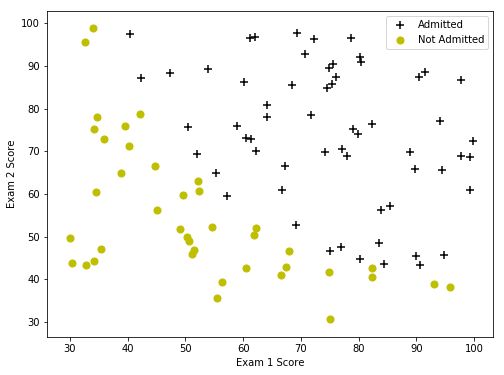

In [21]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='k', marker='+', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='y', marker='o', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

### 구현
#### 시그모이드 함수
두 클래스 사이에 명확한 결정 경계가 있는 것처럼 보입니다. 이제 결과를 예측하기 위해 모델을 훈련 할 수 있도록 로지스틱 회귀를 구현해야 합니다. 실제 비용 함수로 시작하기 전에, 로지스틱 회귀 가설은 다음과 같이 정의됨을 기억하십시오.

$$ h_\theta(x) = g(\mathbf {\theta^T x}) $$

여기에서, 함수 $g()$ 는 시그모이드 함수이며, 다음과 같이 정의됩니다.

$$ g(z) = { 1 \over (1 + e^{-z}) } $$

첫 단계는 다음과 같이 이 함수를 구현하여 나머지 프로그램에서 호출 할 수 있도록 하는 것입니다. 

In [22]:
def sigmoid(z):
    # Problem-1 (5 points) ======================
    sgmd = 1 / (1 + np.exp(-z))
    #============================================
    return sgmd

sigmoid(z)를 호출하여 몇 가지 값을 테스트 해보십시오. x의 큰 양수 값의 경우 sigmoid는 1 에 가까워야 하지만 큰 음수 값의 경우 sigmoid는 0 에 가까워야 합니다. sigmoid(0) 은 정확히 0.5 가 됩니다. 코드는 벡터와 행렬에서도 작동해야 합니다. 행렬의 경우 함수는 모든 요소에서 시그모이드 함수를 수행해야 합니다.

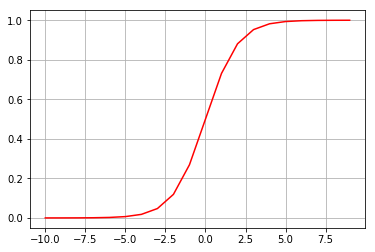

In [23]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(6,4))
ax.grid(True)
ax.plot(nums, sigmoid(nums), 'r')

#### 비용함수(cost function)와 경사(gradient)
이제 로지스틱 회귀에 대한 비용 함수와 그레디언트를 구현할 것입니다. costFunction()의 코드를 완성하여 비용과 그레디언트를 반환하십시오. 로지스틱 회귀 분석에서 비용 함수는 다음과 같다.

$$ J(\theta) = {1\over m} \sum_{i=1}^m [-y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1-h_\theta(x^{(i)}))] $$

비용의 기울기는 $\theta$ 와 동일한 길이의 벡터이며, 여기서 j 번째 요소 (j = 0,1, ..., n의 경우)는 다음과 같이 정의됩니다.
$$ {\partial J(\theta) \over \partial \theta_j } = {1\over m} \sum_{i=1}^m  (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}$$
이 그레디언트는 선형회귀 기울기와 동일하게 보이지만, 선형회귀 분석에서는 $h_\theta (x)$ 의 정의가 다르기 때문에 수식이 실제로는 다릅니다.


In [24]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    # Problem-2 (10) ==============================================
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    J = np.sum(first - second) / (len(X))    
    #==============================================================
    return J

이제 선형회귀 분석을 위해 연습 1에서 했던 것과 비슷한 설정을 해야 합니다.

In [25]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(cols-1)

배열의 모양을 신속하게 확인하여, 모든 것이 잘 보이는지 확인하십시오.

In [26]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

$\theta$ 의 초기 매개변수를 사용하여 cost 함수를 호출하면, 비용은 약 0.693입니다.

In [27]:
cost(theta, X, y)

0.6931471805599453

다음에는 트레이닝 데이터, 레이블 및 일부 매개 변수인 theta로 주어지는 그라디언트(매개 변수 업데이트)를 계산하는 함수, "gradient()"가 필요합니다.

In [28]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    # problem-3 (10) =============================
    error = sigmoid(X * theta.T) - y     
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    #=============================================
    return grad

이 함수에서는 실제로 그라디언트 디센트를 수행하지 않습니다. 단일 그라디언트 단계만 계산합니다. 우리는 파이썬을 사용하기 때문에 SciPy의 "optimize" 네임 스페이스를 사용하여 주어진 함수를 최적화하여 비용과 그라디언트를 계산합니다.

우리의 데이터와 초기 매개 변수 값인 0을 사용하여 그라디언트 메서드에 대한 단일 호출을 살펴 보겠습니다.

In [29]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

이제 SciPy의 truncated newton (TNC) 구현을 사용하여 최적의 매개 변수를 찾을 수 있습니다.

In [30]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

Text(0,0.5,'Exam 2 Score')

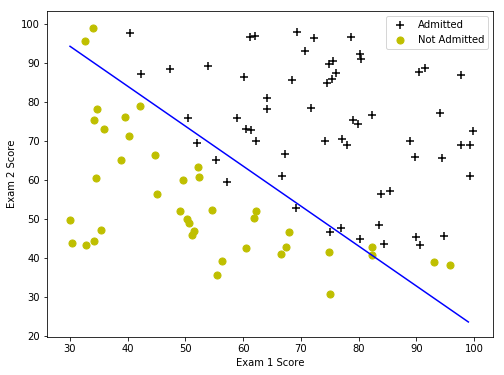

In [31]:
t1 = np.arange(30,100,1)
t2 = -(result[0][0] + t1 * result[0][1]) / result[0][2] 

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='k', marker='+', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='y', marker='o', label='Not Admitted')
ax.plot( t1, t2, 'b-')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

이 솔루션으로 우리 비용이 어떻게 생겼는지 보도록하겠습니다.

In [32]:
cost(result[0], X, y)

0.20349770158947458

다음으로 우리는 학습 된 매개변수 theta를 사용하여 데이터 세트 X에 대한 예측을 출력하는 함수를 작성해야 합니다. 그런 다음, 이 함수를 사용하여 분류 기준의 학습 정확도에 점수를 매길 수 있습니다.

In [33]:
def predict(theta, X):
    # (4) 10 points ======================================
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]
    # ==================================================== 

In [34]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy =',accuracy,'%')
#print'accuracy = {0}%'.format(accuracy)

accuracy = 89 %


## 정규화된 로지스틱 회귀(Regularized logistic regression)

- 이 연습의 두 번째 부분에서는 정규화를 추가하여 로지스틱 회귀 알고리즘을 개선합니다. 정규화는 알고리즘이 "더 단순한" 모델을 선호하게 만드는 비용 함수의 용어입니다 (이 경우 모델은 더 작은 계수). 이론은 과적응(overfitting)을 최소화하고 모델의 일반화 능력을 향상시키는 데 도움이 된다는 것입니다. 

- 당신이 공장의 제품 관리자이고 서로 다른 두 가지 테스트에서 일부 마이크로 칩에 대한 테스트 결과가 있다고 가정합니다. 이 두 가지 검사에서 마이크로 칩을 받아들이거나 거절해야하는지 판단하고 싶습니다. 의사 결정을 돕기 위해 과거의 마이크로 칩에 대한 테스트 결과의 데이터 세트가 있으며 여기서부터 로지스틱 회귀 모델을 구축 할 수 있습니다.

- 파트 1과 마찬가지로 데이터를 시각화하여 시작합시다.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
path = os.getcwd() + '/data/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

FileNotFoundError: File b'/home/nbuser/library/data/ex2data2.txt' does not exist

In [ ]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='k', marker='+', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='y', marker='o', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

- 이 데이터는 이전 예제보다 약간 더 복잡해 보입니다. 특히 이 데이터에서 잘 수행 할 선형 의사 결정 경계가 없음을 알 수 있습니다. 로지스틱 회귀와 같은 선형 기법을 사용하여 이를 처리하는 한 가지 방법은 원래 특징들의 다항식에서 파생된 특징들을 생성하는 것 입니다. 먼저 다항식 특징을 만들어 봅시다.

### 특징 매핑
데이터를 더 잘 맞추는 한 가지 방법은 각 데이터 요소에서 더 많은 특징을 만드는 것입니다. 다음의 함수 mapFeature에서 우리는 x1과 x2의 모든 다항식 항으로 특징를 6 차까지 매핑합니다.

$$ mapFeature([x_1, x_2],6) = [ 1, x_1, x_2, x_1^2, x_1 x_2 , x_2^2, x_1^3, \cdots, x_1x_2^5, x_2^6]^T $$ 


In [ ]:
def mapFeature(data, degree):
    x1 = data['Test 1']
    x2 = data['Test 2']

    data.insert(3, 'Ones', 1)

    for i in range(1, degree+2):
        for j in range(0, i):
            data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

    data.drop('Test 1', axis=1, inplace=True)
    data.drop('Test 2', axis=1, inplace=True)
    return data

data2 = mapFeature(data2, 3)
data2.head()

이 매핑의 결과로 두 개의 피쳐 (두 개의 QA 테스트의 점수) 벡터가 28 차원 벡터로 변형되었습니다. 이 더 높은 차원의 특성 벡터에 대해 학습 된 로지스틱 회귀 분류자는보다 복잡한 결정 경계를 가지며 2 차원 플롯에서 그릴 때 비선형으로 나타납니다.

특 징 매핑을 사용하면 보다 표현력있는 분류 기준을 만들 수 있지만 지나치게 적합(적응)되기 쉽습니다. 연습의 다음 부분에서는 데이터에 맞게 정규화 된 로지스틱 회귀를 구현하고 정규화가 어떻게 과적합 문제를 해결하는 데 도움이되는지 직접 확인하게 됩니다.

이제 정규화 항을 포함하기 위해 파트 1의 비용 및 그래디언트 함수를 수정해야 합니다. 먼저 비용 함수 :

로지스틱 회귀에서의 정규화 된 비용 함수는 다음과 같다.

$$ J(\theta) = {1 \over m} \sum_{i=1}^m [-y^{(i)} \log (h_\theta (x^{(i)}))- (1-y^{(i)} )\log (1-h_\theta (x^{(i)}))] + {\lambda \over 2m} \sum_{j=1}^n \theta_j^2 $$

매개변수 $\theta_0$을 정규화해서는 안됩니다. 

In [ ]:
def costReg(theta, X, y, reg):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (reg / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

비용 함수의 기울기는 j 번째 요소가 다음과 같이 정의되는 벡터입니다.
$$ {\partial J (\theta) \over \partial \theta_0 } = {1\over m }\sum_{i=1}^m (h_\theta (x^{(i)}) - y^{(i)})x_j^{(i)}    \quad \textrm{for} \quad j=0 $$
$$ {\partial J (\theta) \over \partial \theta_0 } = {1\over m }\sum_{i=1}^m (h_\theta (x^{(i)}) - y^{(i)})x_j^{(i)}    + {\lambda \over m} \theta_j \quad \textrm{for} \quad j\ge 0 $$


방정식에서 "reg"용어를 주목하십시오. 또한 "학습 속도"매개 변수 추가에 유의하십시오. 이것은 정규화 용어의 효과를 제어하는 하이퍼 매개 변수입니다. 이제 그라디언트 함수에 정규화를 추가해야 합니다.

In [ ]:
def gradientReg(theta, X, y, reg):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((reg / len(X)) * theta[:,i])
    
    return grad

1 부에서 했던 것처럼 변수를 초기화하십시오.

In [ ]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

우리의 학습 속도를 합리적인 값으로 초기화합시다. 필요한 경우 나중에 처리 할 수 있습니다 (예 : 페널티가 너무 강하거나 충분하지 않은 경우).

In [ ]:
reg = 0.01

이제 계산이 작동하는지 확인하기 위해 theta에 대한 기본값 (0)으로 새 정규화 함수를 호출 해 봅시다.

In [ ]:
costReg(theta2, X2, y2, reg)

In [ ]:
gradientReg(theta2, X2, y2, reg)

이제 파트 1의 동일한 최적화 함수를 사용하여 최적의 솔루션을 계산할 수 있습니다.

In [ ]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, reg))
theta2 = result2[0]
theta2

마지막으로 파트 1의 예측 함수를 사용하여 솔루션이 훈련 데이터에 얼마나 정확한지 확인할 수 있습니다.

In [ ]:
theta_min = np.matrix(theta2)
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy =',accuracy,'%')
# print 'accuracy = {0}%'.format(accuracy)

이러한 알고리즘을 처음부터 구현했지만 scikit-learn과 같은 고수준의 파이썬 라이브러리를 사용하여이 문제를 해결할 수도 있습니다.

In [ ]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

In [ ]:
model.score(X2, y2)

정확도는 방금 계산 한 것보다 훨씬 낮지 만,이 결과는 scikit-learn에서 제공하는 기본 매개 변수를 사용하고 있음을 명심하십시오. 이전 결과에서 얻은 정확도와 동일한 정확성을 얻으려면 매개 변수 튜닝이 필요할 것입니다.

그것은 연습 2를위한 모든 것입니다! 다음 연습을 위해 계속 지켜봐주십시오. 여기서 우리는 멀티 클래스 이미지 분류를 다루게 될 것입니다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
path = os.getcwd() + '/data/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='k', marker='+', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='y', marker='o', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

delta = 0.02
t1, t2 = meshgrid(
    arange(-1.2, 1.2, delta),
    arange(-1.2, 1.2, delta)
)

matplotlib.pyplot.contour(
    t1, t2,
    theta2[0] + theta2[1]*t1 + theta2[2]*t2 + 
    theta2[3]*t1*t1 + theta2[4]*t1*t2 + theta2[5]*t2*t2 + 
    theta2[6]*t1*t1*t1 + theta2[7]*t2*t1*t1 + theta2[8]*t1*t2*t2 + theta2[9]*t2*t2*t2,
    [0]
)
matplotlib.pyplot.show()
